In [93]:
from scipy.stats import dirichlet
from scipy.special import kl_div
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets

import os

In [138]:
# データセット可視化メソッド
def plot_data(X_train, y_train, name):
    plt.figure(figsize=(12,5))

    # true
    # plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name}')

    plt.tight_layout()
    plt.show()

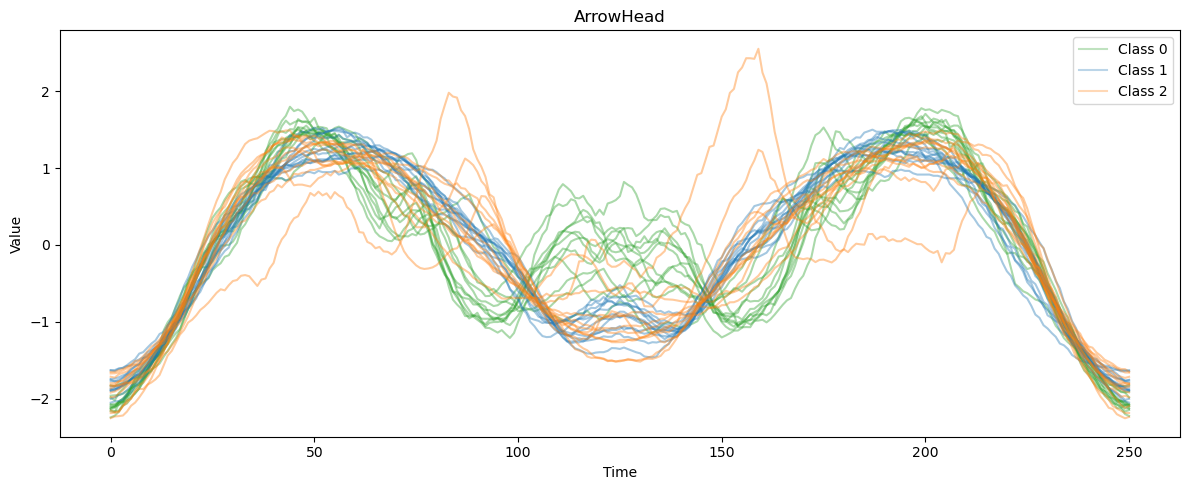

In [139]:
data_name = 'ArrowHead'

# データセットの読み込み（ここではUCR/UEAデータセットを使用）
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)

plot_data(X_train, y_train, data_name)

In [140]:
y_train

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

trainデータの形状確認

In [141]:
X_train[:,:,0].shape

(36, 251)

trainデータ全体の頻度分布をからbinsの設定を取得

In [142]:
hist, bin_edges = np.histogram(X_train[:,:,0].T, bins='auto', density=False)
print('hist:', hist,'\nbin_edges:', bin_edges)

bin_max = bin_edges.max()
bin_min = bin_edges.min()
bin_num = len(hist)

print('bin_max:', bin_max, '\nbin_min:', bin_min, '\nbin_num:', bin_num)

hist: [ 59 114 214 237 240 210 386 508 491 486 379 354 385 420 435 414 433 439
 502 622 737 541 346  56  15   5   1   3   4] 
bin_edges: [-2.2570801  -2.09118071 -1.92528131 -1.75938192 -1.59348253 -1.42758313
 -1.26168374 -1.09578435 -0.92988496 -0.76398556 -0.59808617 -0.43218678
 -0.26628738 -0.10038799  0.0655114   0.2314108   0.39731019  0.56320958
  0.72910898  0.89500837  1.06090776  1.22680716  1.39270655  1.55860594
  1.72450533  1.89040473  2.05630412  2.22220351  2.38810291  2.5540023 ]
bin_max: 2.5540023 
bin_min: -2.2570801 
bin_num: 29


上記のbins設定でtraiｎデータ全体を頻度分布に変換

In [143]:
hist_li = []
for d in range(X_train.shape[0]):
    hist_ = np.histogram(X_train[d], bins=bin_num, range=(bin_min, bin_max), density=False)[0] + 0.000001
    hist_li.append(hist_ / hist_.sum()) # 合計を１にスケール

X_hist = np.array(hist_li)
X_hist

array([[3.98406328e-09, 1.59362571e-02, 3.98406368e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 1.99203204e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 4.38247001e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       ...,
       [1.19521938e-02, 2.78884470e-02, 1.59362571e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 3.98406368e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09],
       [3.98406328e-09, 3.98406328e-09, 2.78884470e-02, ...,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09]])

In [144]:
X_hist.shape

(36, 29)

In [145]:
X_hist[0]

array([3.98406328e-09, 1.59362571e-02, 3.98406368e-02, 2.39043837e-02,
       2.39043837e-02, 1.19521938e-02, 1.59362571e-02, 1.19521938e-02,
       4.38247001e-02, 1.23505966e-01, 1.23505966e-01, 4.78087634e-02,
       2.78884470e-02, 2.39043837e-02, 1.59362571e-02, 4.78087634e-02,
       5.57768900e-02, 4.78087634e-02, 4.78087634e-02, 4.38247001e-02,
       5.17928267e-02, 4.38247001e-02, 1.11553776e-01, 3.98406328e-09,
       3.98406328e-09, 3.98406328e-09, 3.98406328e-09, 3.98406328e-09,
       3.98406328e-09])

In [146]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [147]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)

version. 5.8.0


### １つのデータに対するパラメータ推定

モデル定義

In [148]:
data_ = X_hist[0]
data_

array([3.98406328e-09, 1.59362571e-02, 3.98406368e-02, 2.39043837e-02,
       2.39043837e-02, 1.19521938e-02, 1.59362571e-02, 1.19521938e-02,
       4.38247001e-02, 1.23505966e-01, 1.23505966e-01, 4.78087634e-02,
       2.78884470e-02, 2.39043837e-02, 1.59362571e-02, 4.78087634e-02,
       5.57768900e-02, 4.78087634e-02, 4.78087634e-02, 4.38247001e-02,
       5.17928267e-02, 4.38247001e-02, 1.11553776e-01, 3.98406328e-09,
       3.98406328e-09, 3.98406328e-09, 3.98406328e-09, 3.98406328e-09,
       3.98406328e-09])

In [149]:
data_.sum()

1.0000000000000002

In [150]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[0])]

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(1), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('var'))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('var',), sigma=1)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_, observed=x, dims=('var'))
    # # likelihood
    # result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_dirichlet.model)

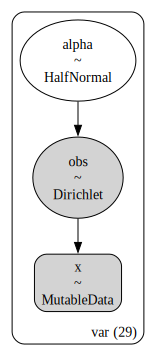

In [151]:
# 構造
modeldag = pm.model_to_graphviz(model_dirichlet)
display(modeldag)


In [152]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Compiling...
Compilation time =  0:00:00.201165
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:01<00:00, 2934.09it/s] 

Sampling time =  0:00:01.410778
Transforming variables...
Transformation time =  0:00:00.004008
CPU times: user 1.95 s, sys: 62.5 ms, total: 2.01 s
Wall time: 1.77 s


In [153]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Max rhat: 1.0013682618540032


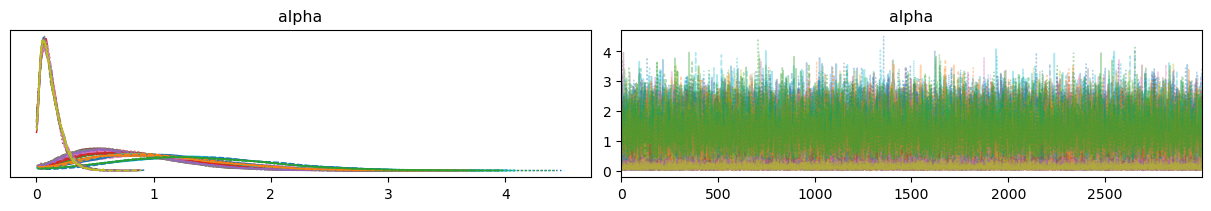

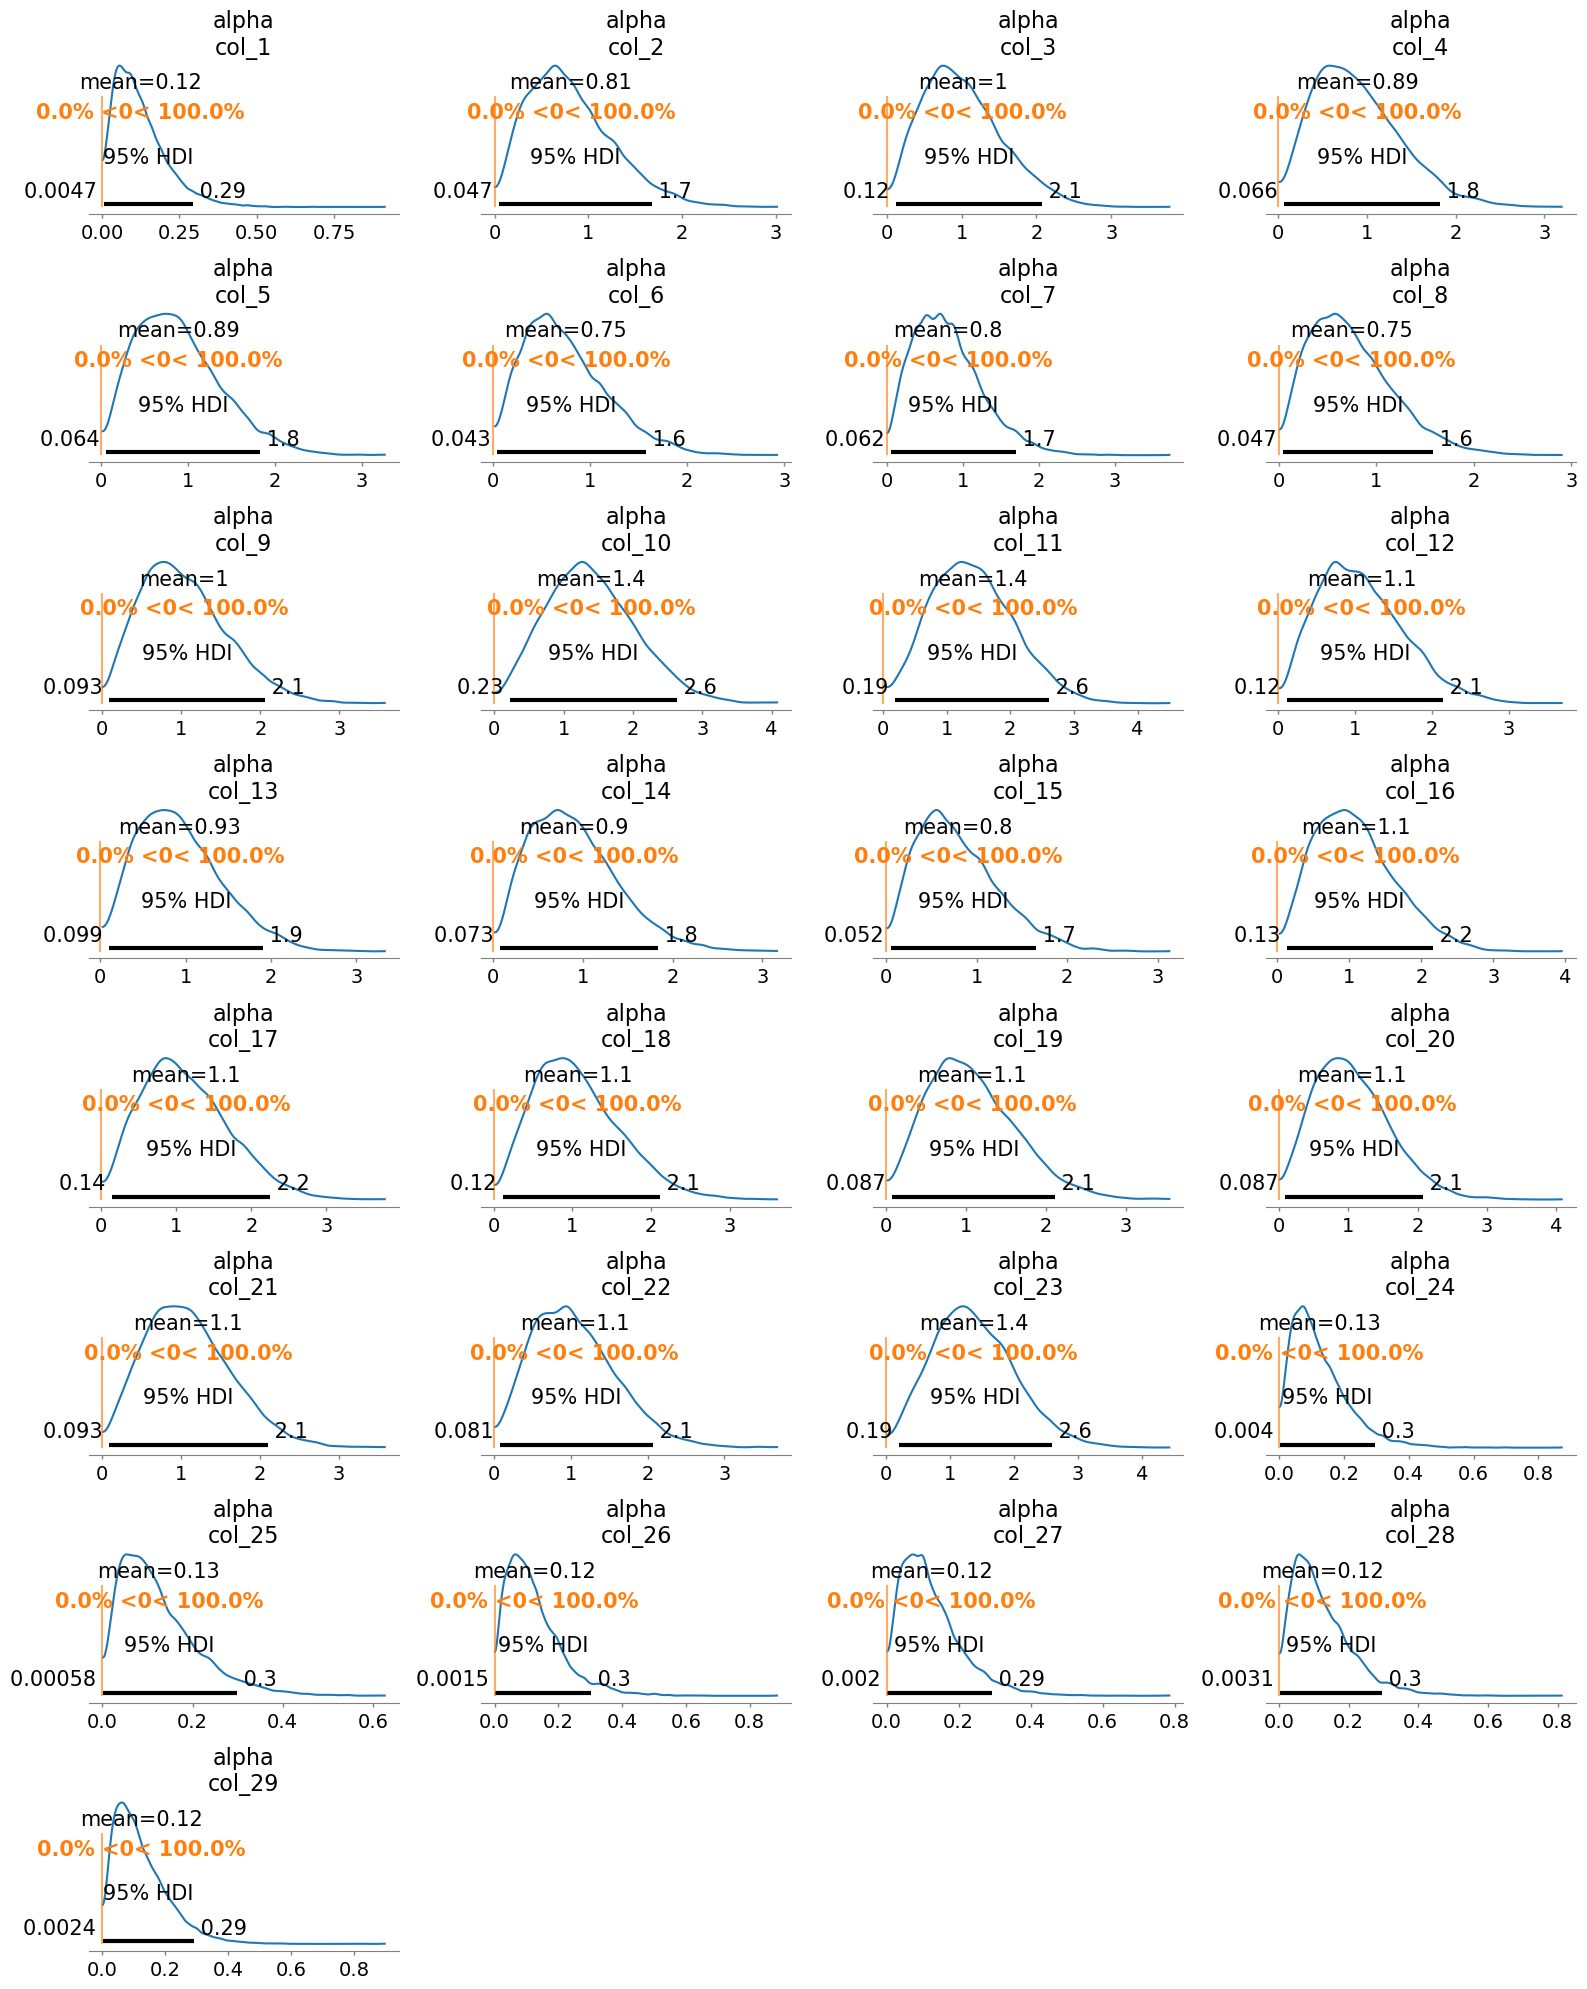

In [154]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['alpha']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['alpha'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


In [155]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[col_1],0.124,0.086,0.002,0.278,0.001,0.001,9539.0,4846.0,1.0
alpha[col_2],0.812,0.455,0.047,1.610,0.004,0.003,7722.0,4407.0,1.0
alpha[col_3],1.014,0.533,0.130,2.008,0.006,0.004,6291.0,3572.0,1.0
alpha[col_4],0.892,0.491,0.098,1.795,0.005,0.003,9244.0,4769.0,1.0
alpha[col_5],0.892,0.489,0.068,1.752,0.005,0.003,9080.0,4543.0,1.0
alpha[col_6],0.751,0.432,0.049,1.526,0.004,0.003,7617.0,4323.0,1.0
alpha[col_7],0.805,0.455,0.055,1.632,0.005,0.003,7424.0,4353.0,1.0
alpha[col_8],0.748,0.430,0.044,1.520,0.004,0.003,8184.0,4680.0,1.0
alpha[col_9],1.038,0.543,0.116,2.018,0.006,0.004,7174.0,3794.0,1.0
alpha[col_10],1.398,0.645,0.233,2.557,0.007,0.005,7475.0,3933.0,1.0


In [156]:
df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
df_summary['alpha_normal']

alpha[col_1]     0.005327
alpha[col_2]     0.034886
alpha[col_3]     0.043564
alpha[col_4]     0.038323
alpha[col_5]     0.038323
alpha[col_6]     0.032265
alpha[col_7]     0.034585
alpha[col_8]     0.032136
alpha[col_9]     0.044595
alpha[col_10]    0.060062
alpha[col_11]    0.060835
alpha[col_12]    0.046529
alpha[col_13]    0.040041
alpha[col_14]    0.038752
alpha[col_15]    0.034198
alpha[col_16]    0.046572
alpha[col_17]    0.048376
alpha[col_18]    0.045712
alpha[col_19]    0.046443
alpha[col_20]    0.045283
alpha[col_21]    0.047130
alpha[col_22]    0.045197
alpha[col_23]    0.058773
alpha[col_24]    0.005370
alpha[col_25]    0.005370
alpha[col_26]    0.005327
alpha[col_27]    0.005370
alpha[col_28]    0.005327
alpha[col_29]    0.005327
Name: alpha_normal, dtype: float64

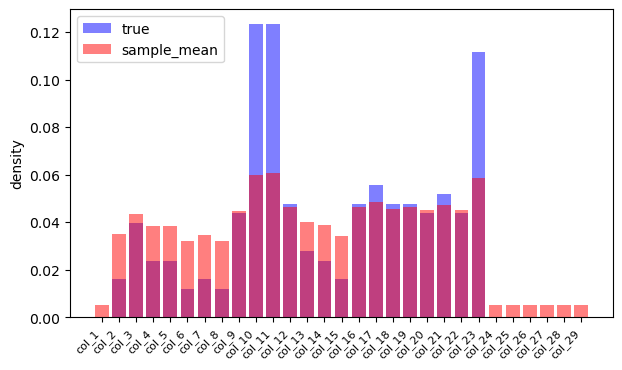

In [157]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_, color='blue', alpha=0.5, label='true')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_summary['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

↑データの相対的な大小は反映できているが、絶対値のずれが大きい

alpha_の事前分布のsigmaを100にして再度実行

In [158]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[0])]

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(1), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('var'))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('var',), sigma=100)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_, observed=x, dims=('var'))
    # # likelihood
    # result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_dirichlet.model)

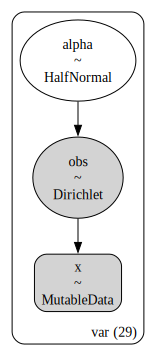

In [159]:
# 構造
modeldag = pm.model_to_graphviz(model_dirichlet)
display(modeldag)


In [160]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Compiling...
Compilation time =  0:00:00.213336
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:01<00:00, 3034.68it/s]

Sampling time =  0:00:01.366386
Transforming variables...
Transformation time =  0:00:00.003808
CPU times: user 1.86 s, sys: 61.2 ms, total: 1.92 s
Wall time: 1.75 s


Max rhat: 1.0014704517044206


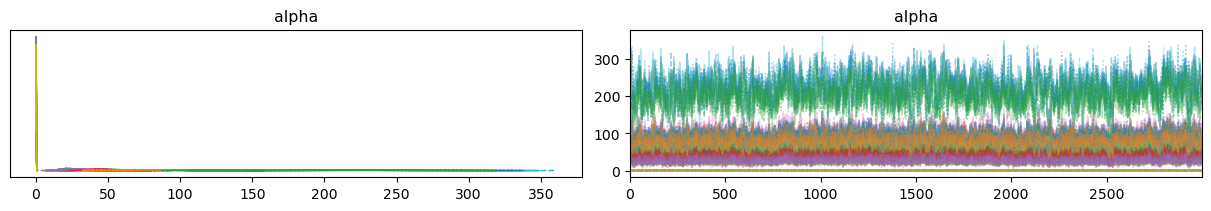

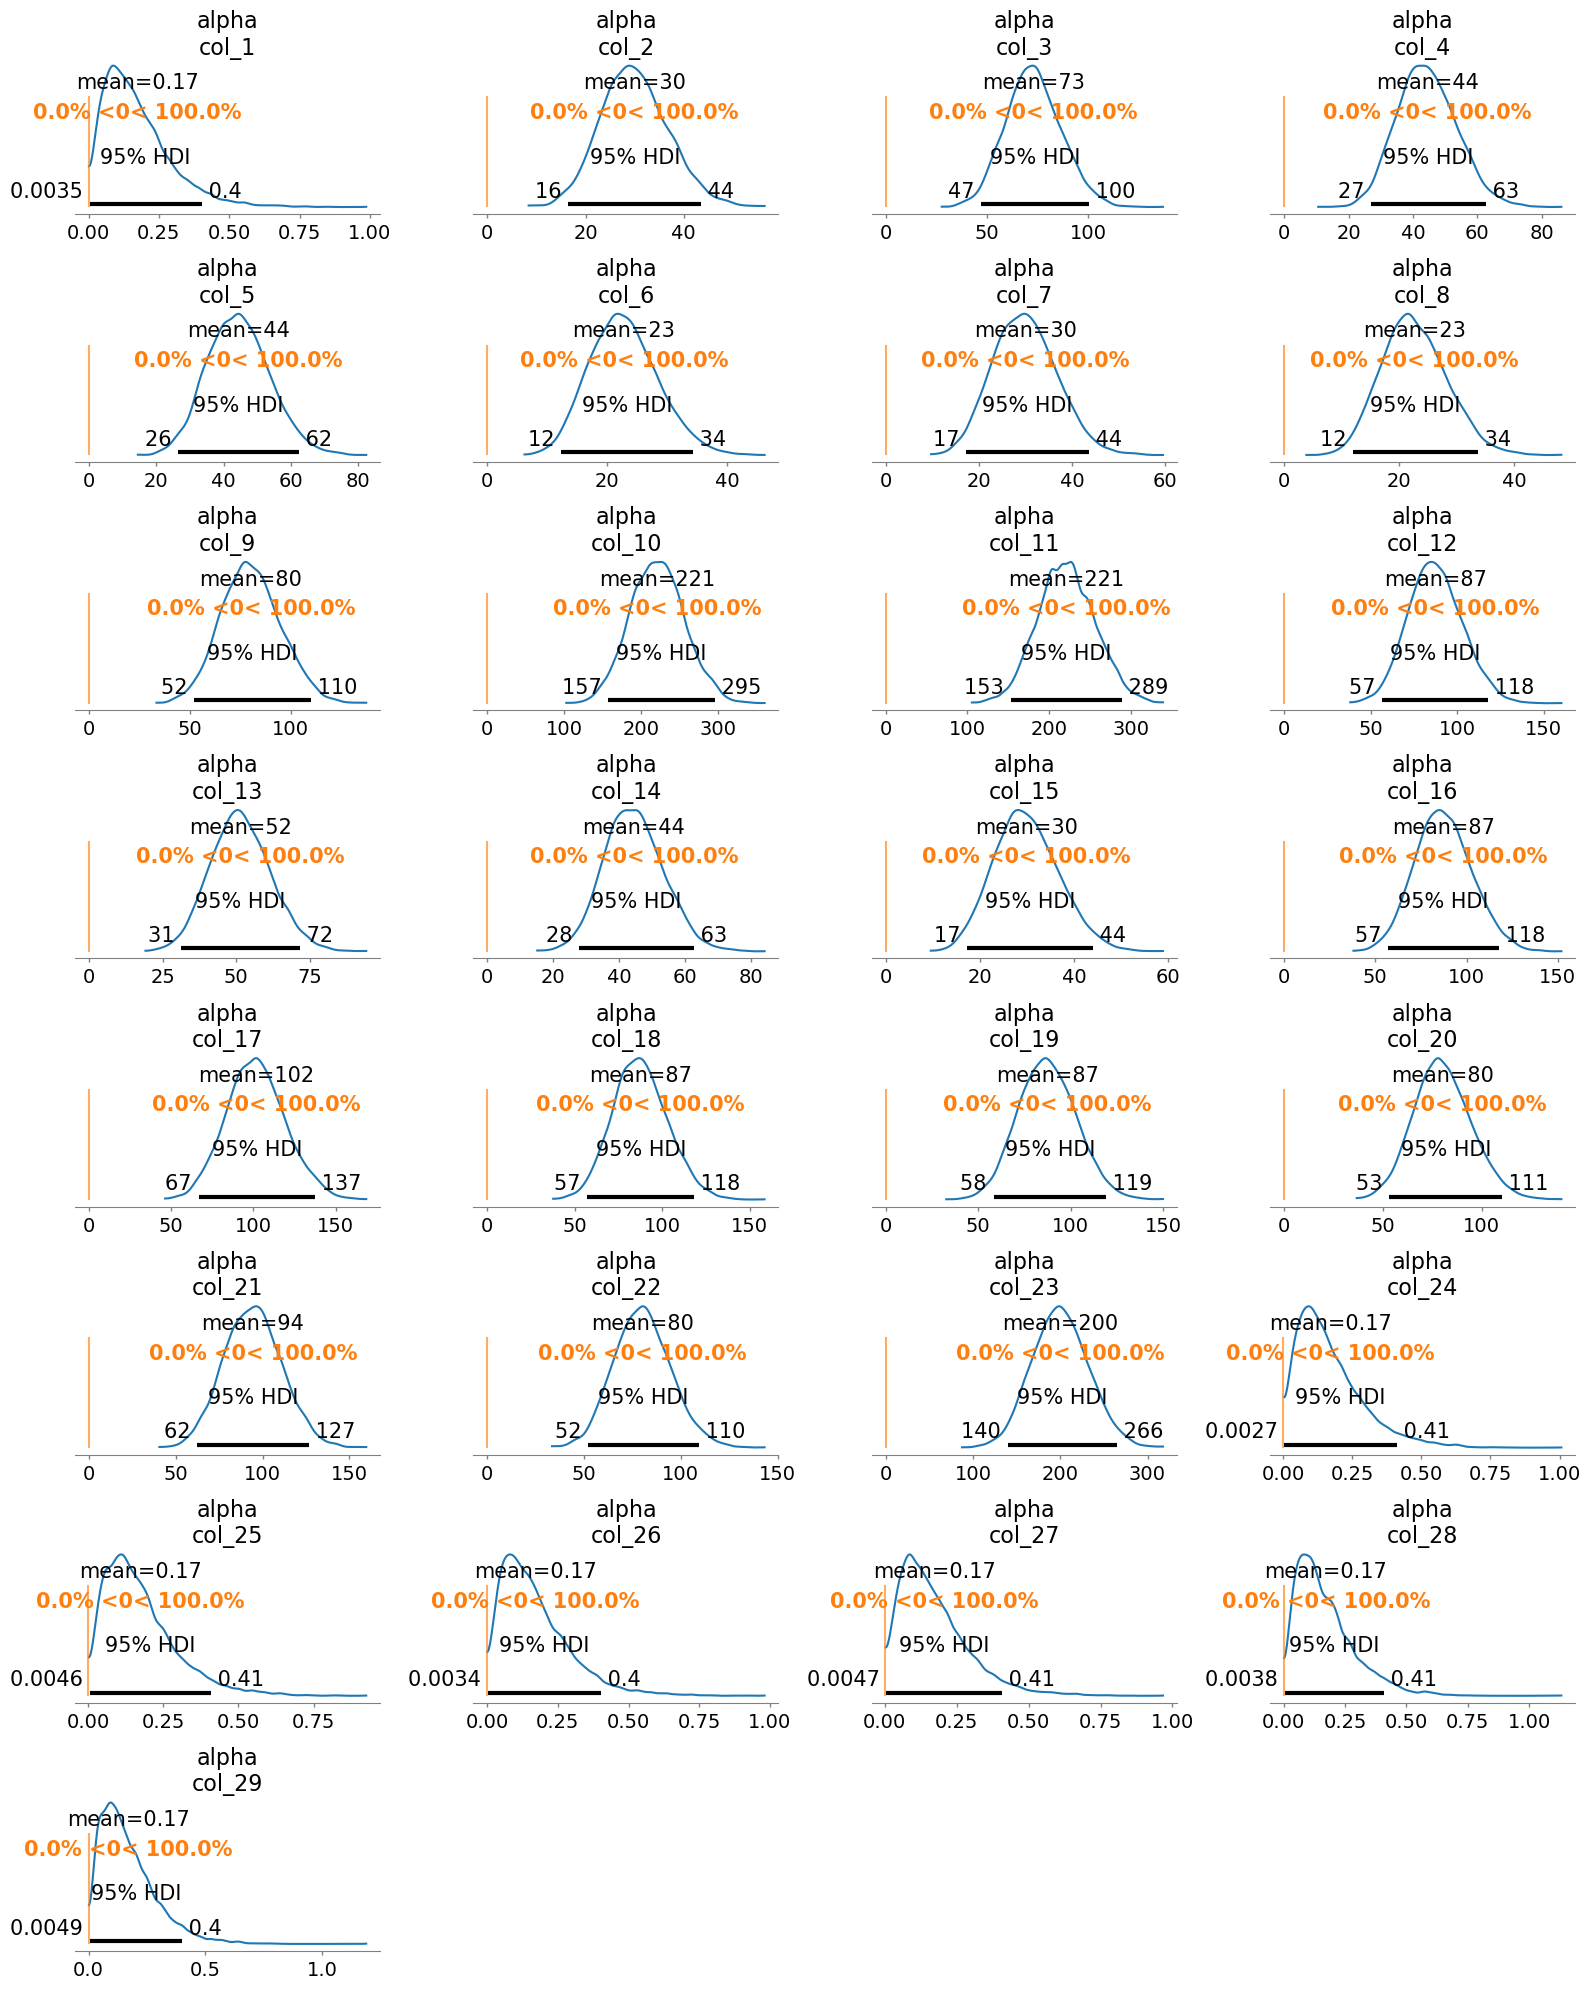

In [161]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['alpha']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['alpha'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


In [162]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
df_summary['alpha_normal']
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,alpha_normal
alpha[col_1],0.172,0.119,0.008,0.390,0.001,0.001,6260.0,4466.0,1.0,0.000094
alpha[col_2],29.992,6.922,17.437,43.315,0.194,0.137,1257.0,2792.0,1.0,0.016454
alpha[col_3],72.962,13.670,47.901,98.919,0.462,0.327,869.0,1782.0,1.0,0.040028
alpha[col_4],44.402,9.235,27.067,61.139,0.280,0.198,1078.0,2272.0,1.0,0.024359
alpha[col_5],44.395,9.262,27.656,62.411,0.282,0.199,1074.0,2659.0,1.0,0.024356
alpha[col_6],22.765,5.679,12.570,33.674,0.142,0.100,1584.0,3315.0,1.0,0.012489
alpha[col_7],29.926,6.859,17.376,42.658,0.182,0.129,1391.0,2904.0,1.0,0.016418
alpha[col_8],22.704,5.690,12.001,32.950,0.143,0.101,1565.0,3071.0,1.0,0.012456
alpha[col_9],80.222,14.767,52.837,108.224,0.501,0.354,867.0,1818.0,1.0,0.044011
alpha[col_10],221.117,35.128,157.856,291.151,1.328,0.939,697.0,1332.0,1.0,0.121307


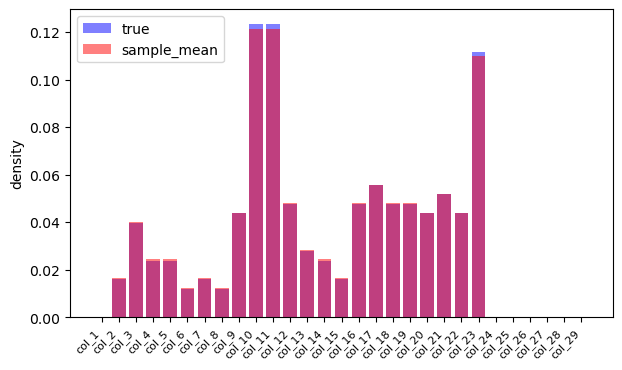

In [163]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_, color='blue', alpha=0.5, label='true')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_summary['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

事前分布のシグマを大きくすることで、データに近いパラメータが学習できた

頻度分布は山があるものなので、alphaは大きい必要がありそう

### 複数データに対するパラメータ推定

In [179]:
y_train==0

array([ True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False])

In [180]:
data_ = X_hist[y_train==0]
print('shape:', data_.shape)
data_

shape: (12, 29)


array([[3.98406328e-09, 1.59362571e-02, 3.98406368e-02, 2.39043837e-02,
        2.39043837e-02, 1.19521938e-02, 1.59362571e-02, 1.19521938e-02,
        4.38247001e-02, 1.23505966e-01, 1.23505966e-01, 4.78087634e-02,
        2.78884470e-02, 2.39043837e-02, 1.59362571e-02, 4.78087634e-02,
        5.57768900e-02, 4.78087634e-02, 4.78087634e-02, 4.38247001e-02,
        5.17928267e-02, 4.38247001e-02, 1.11553776e-01, 3.98406328e-09,
        3.98406328e-09, 3.98406328e-09, 3.98406328e-09, 3.98406328e-09,
        3.98406328e-09],
       [3.98406328e-09, 3.98406368e-02, 1.99203204e-02, 2.39043837e-02,
        1.59362571e-02, 1.19521938e-02, 1.19521938e-02, 4.78087634e-02,
        6.37450165e-02, 6.37450165e-02, 3.98406368e-02, 5.17928267e-02,
        4.78087634e-02, 9.16334595e-02, 6.77290798e-02, 4.38247001e-02,
        5.57768900e-02, 5.17928267e-02, 2.78884470e-02, 1.99203204e-02,
        4.38247001e-02, 4.78087634e-02, 7.56972064e-02, 3.58565735e-02,
        3.98406328e-09, 3.98406328e-09,

In [181]:
data_.sum()

12.0

In [182]:
data_.mean(axis=0)

array([1.06241727e-02, 2.58964153e-02, 2.32403731e-02, 2.02523257e-02,
       1.69322729e-02, 1.46082360e-02, 1.92563099e-02, 4.94687898e-02,
       5.74369163e-02, 6.73970746e-02, 5.57768900e-02, 4.68127476e-02,
       4.84727739e-02, 5.41168636e-02, 5.74369163e-02, 5.41168636e-02,
       5.51128794e-02, 4.68127476e-02, 4.78087634e-02, 3.98406368e-02,
       4.15006632e-02, 5.34528531e-02, 7.23771537e-02, 1.75962835e-02,
       3.65206200e-03, 3.98406328e-09, 3.98406328e-09, 3.98406328e-09,
       3.98406328e-09])

In [183]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('var',), sigma=1)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_, observed=x, dims=('data','var'))
    # # likelihood
    # result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_dirichlet.model)

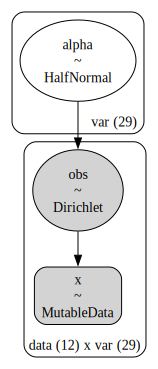

In [184]:
# 構造
modeldag = pm.model_to_graphviz(model_dirichlet)
display(modeldag)


In [185]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Compiling...
Compilation time =  0:00:00.287286
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:01<00:00, 2943.82it/s]

Sampling time =  0:00:01.409550
Transforming variables...
Transformation time =  0:00:00.004013
CPU times: user 1.97 s, sys: 73.8 ms, total: 2.05 s
Wall time: 1.9 s


Max rhat: 1.001353418067107


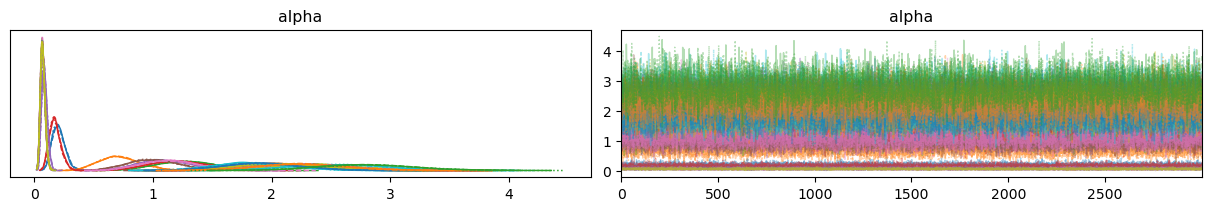

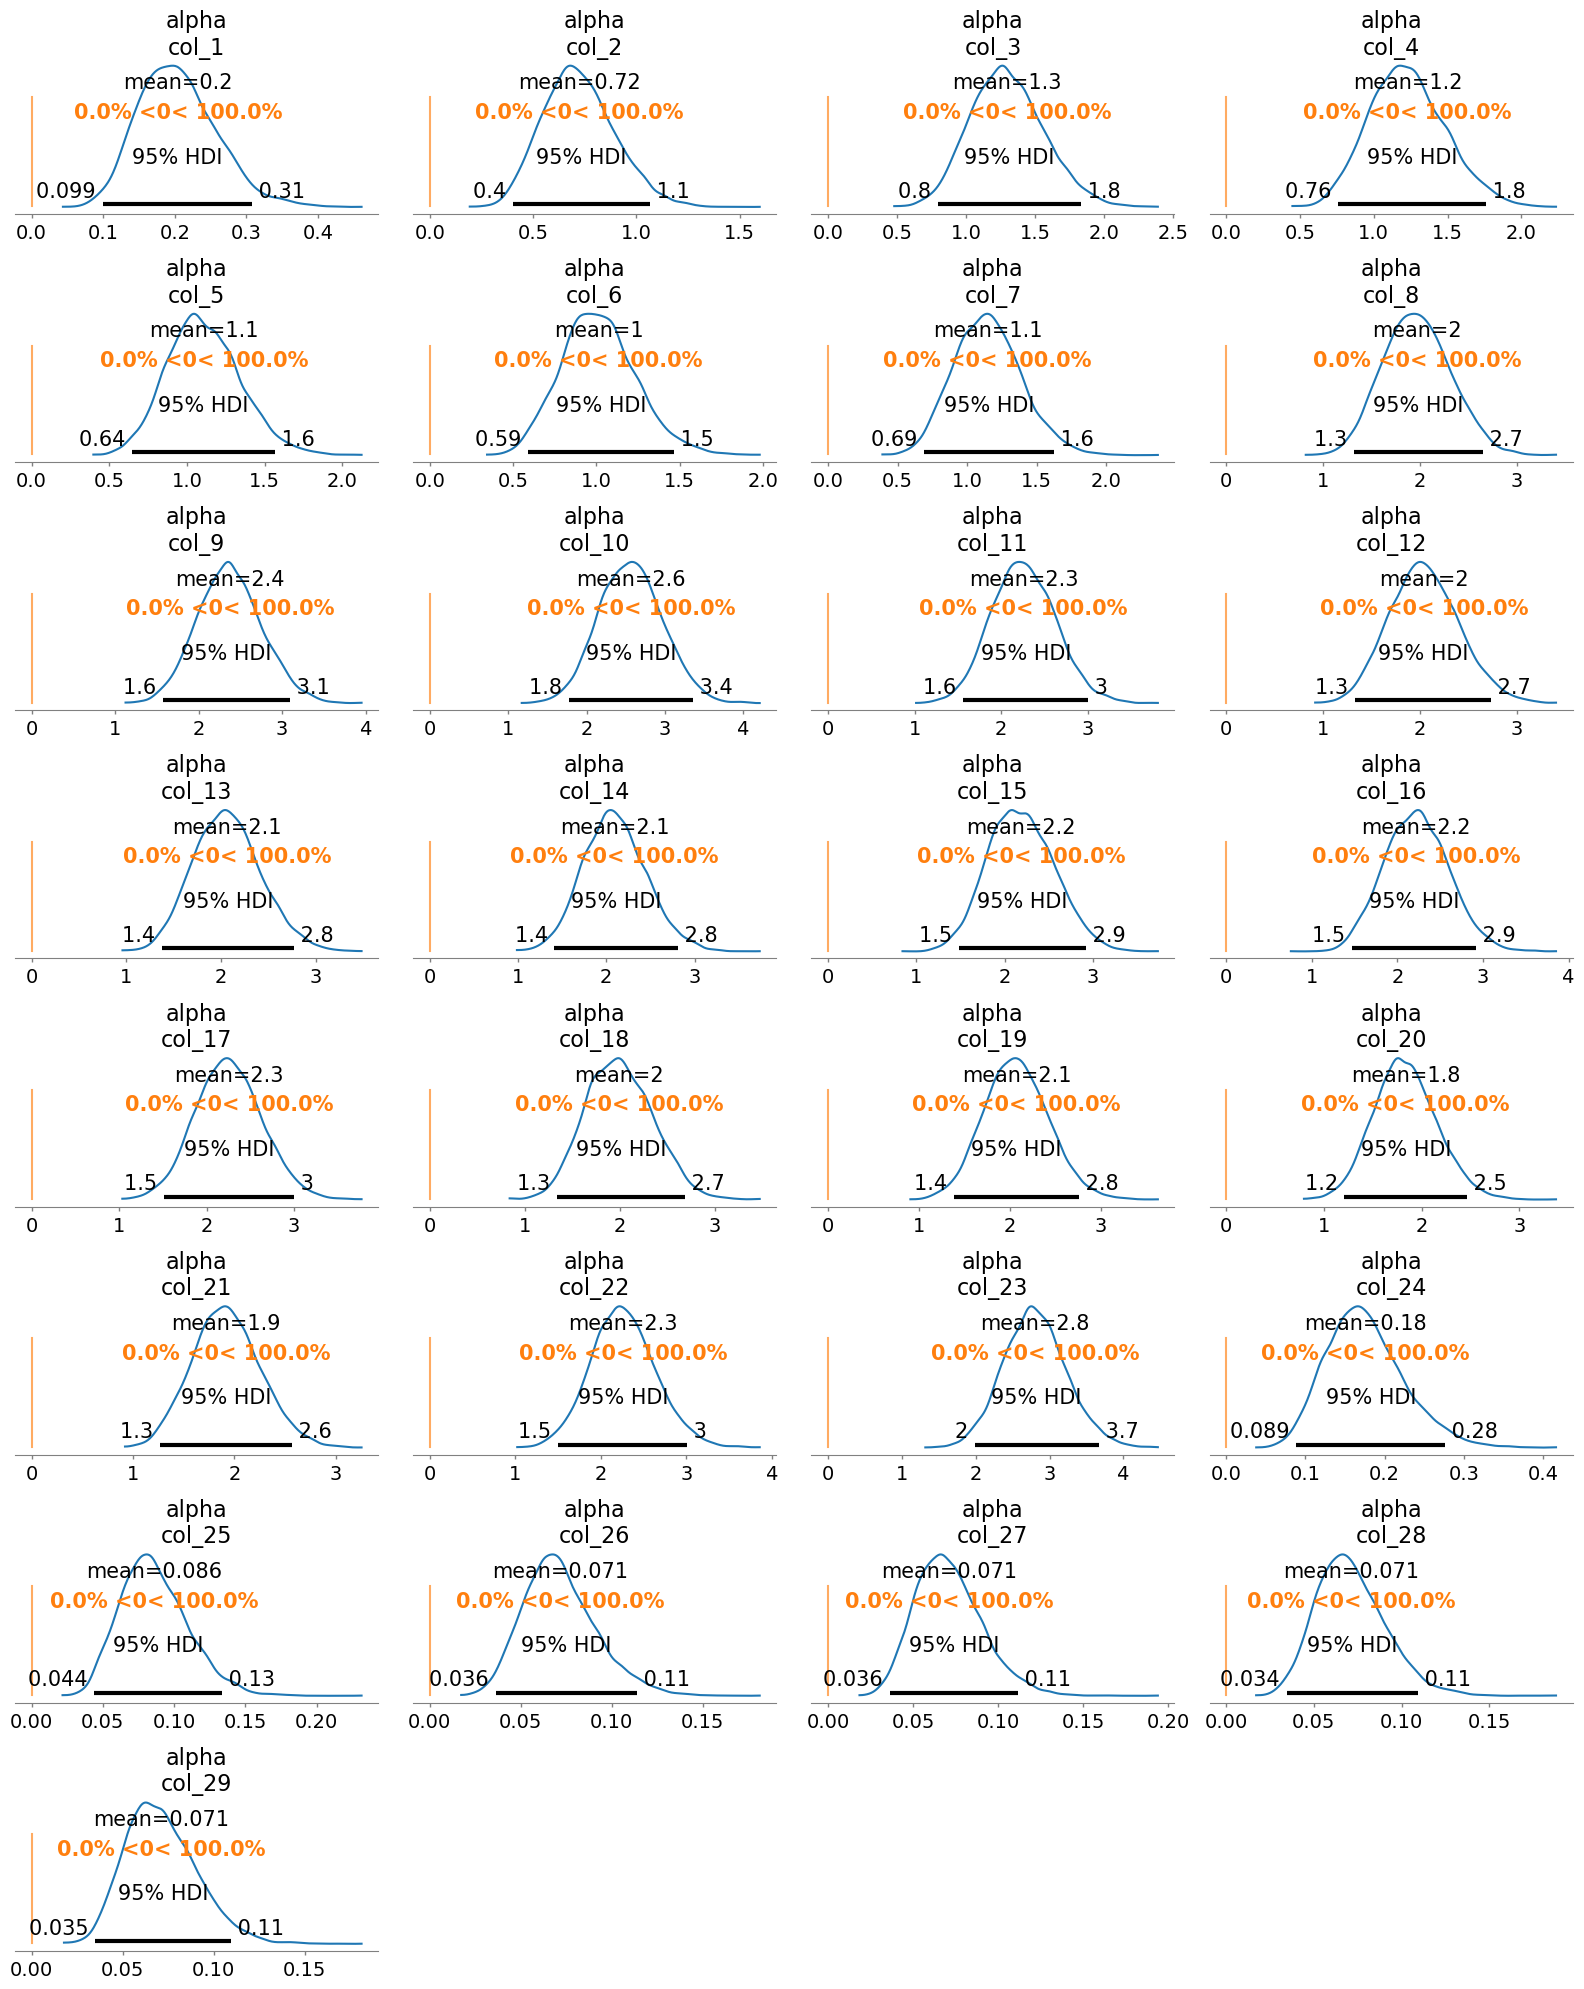

In [186]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['alpha']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['alpha'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


In [187]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
df_summary['alpha_normal']
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,alpha_normal
alpha[col_1],0.204,0.055,0.108,0.307,0.000,0.000,14136.0,6636.0,1.0,0.004834
alpha[col_2],0.723,0.174,0.414,1.053,0.001,0.001,14063.0,6462.0,1.0,0.017134
alpha[col_3],1.298,0.266,0.799,1.787,0.002,0.002,13438.0,6469.0,1.0,0.030760
alpha[col_4],1.229,0.258,0.757,1.724,0.002,0.002,13017.0,6001.0,1.0,0.029125
alpha[col_5],1.109,0.236,0.678,1.561,0.002,0.001,15597.0,5975.0,1.0,0.026281
alpha[col_6],1.013,0.225,0.582,1.422,0.002,0.001,14342.0,6132.0,1.0,0.024006
alpha[col_7],1.148,0.243,0.700,1.606,0.002,0.002,11734.0,6433.0,1.0,0.027206
alpha[col_8],1.968,0.347,1.352,2.640,0.003,0.002,12136.0,6037.0,1.0,0.046638
alpha[col_9],2.373,0.387,1.652,3.104,0.003,0.002,12039.0,6526.0,1.0,0.056236
alpha[col_10],2.568,0.407,1.814,3.333,0.004,0.003,11837.0,6671.0,1.0,0.060857


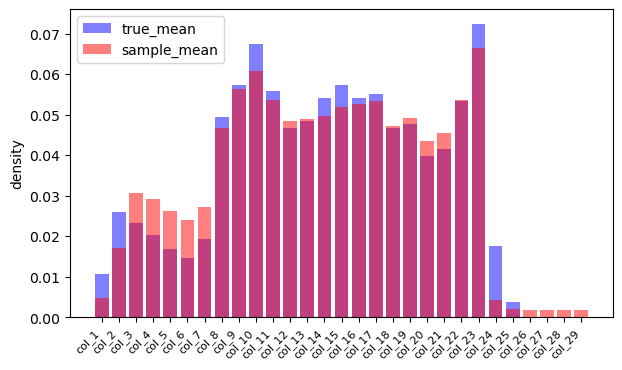

In [188]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_.mean(axis=0), color='blue', alpha=0.5, label='true_mean')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_summary['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

事前分布のシグマを100に変更

In [189]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('var',), sigma=100)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_, observed=x, dims=('data','var'))
    # # likelihood
    # result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_dirichlet.model)

In [190]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Compiling...
Compilation time =  0:00:00.275721
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:01<00:00, 3057.08it/s]

Sampling time =  0:00:01.358585
Transforming variables...
Transformation time =  0:00:00.003834
CPU times: user 2.18 s, sys: 58.7 ms, total: 2.24 s
Wall time: 2.1 s


Max rhat: 1.0014017011567025


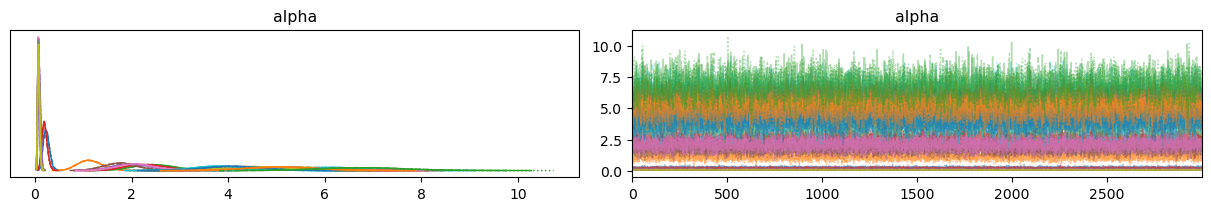

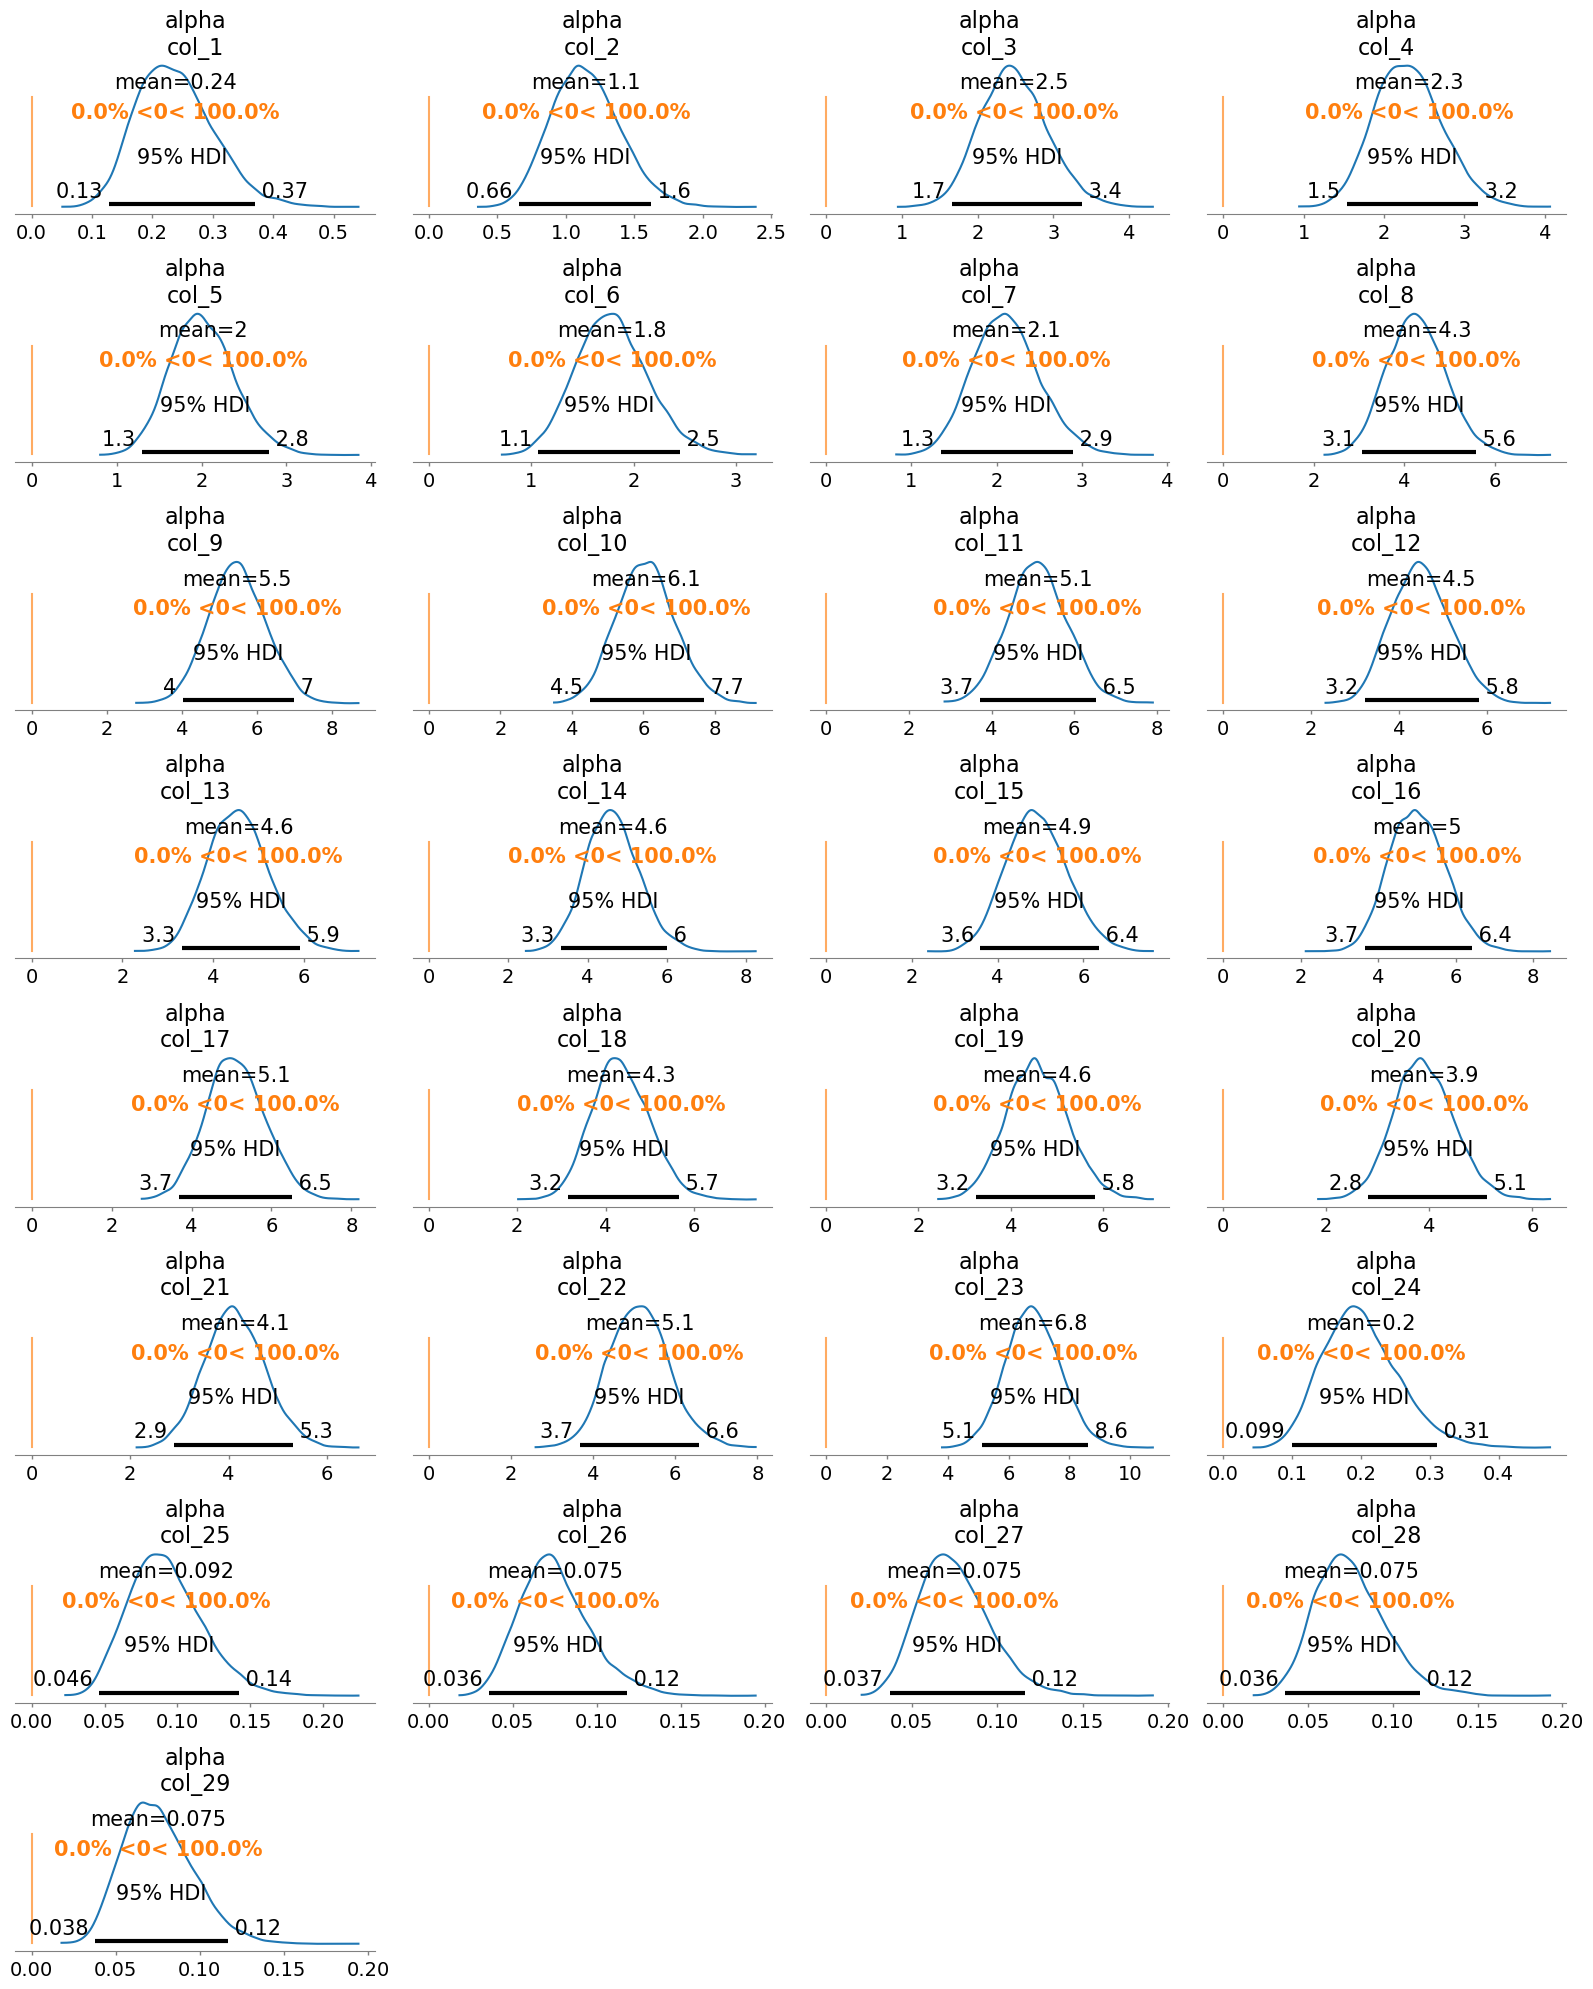

In [191]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['alpha']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['alpha'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


In [192]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
df_summary['alpha_normal']
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,alpha_normal
alpha[col_1],0.238,0.064,0.131,0.363,0.001,0.000,13925.0,6923.0,1.0,0.002610
alpha[col_2],1.148,0.251,0.679,1.608,0.003,0.002,9744.0,7019.0,1.0,0.012587
alpha[col_3],2.479,0.442,1.675,3.315,0.005,0.004,7232.0,6335.0,1.0,0.027181
alpha[col_4],2.307,0.421,1.543,3.110,0.005,0.003,7371.0,6450.0,1.0,0.025295
alpha[col_5],2.016,0.381,1.310,2.739,0.004,0.003,8659.0,5599.0,1.0,0.022104
alpha[col_6],1.791,0.353,1.160,2.486,0.004,0.003,8730.0,5726.0,1.0,0.019637
alpha[col_7],2.113,0.397,1.384,2.875,0.005,0.003,7423.0,5964.0,1.0,0.023168
alpha[col_8],4.273,0.647,3.050,5.459,0.009,0.006,5074.0,5493.0,1.0,0.046851
alpha[col_9],5.467,0.762,4.111,6.966,0.011,0.008,4541.0,6093.0,1.0,0.059942
alpha[col_10],6.069,0.817,4.551,7.616,0.012,0.009,4565.0,6181.0,1.0,0.066542


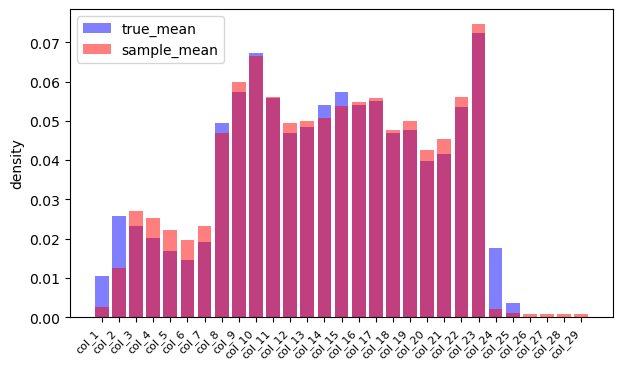

In [193]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_.mean(axis=0), color='blue', alpha=0.5, label='true_mean')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_summary['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示